# Probabilistic Programming 2: Message passing on factor graphs

#### Goal 
  - Practice forming factor graphs out of probabilistic models.
  - Familiarize yourself with message passing on factor graphs.
  - Practice specifying models and inference procedures in a probabilistic programming language.

#### Materials        
  - Mandatory
    - This notebook
    - Lecture notes on factor graphs
    - Lecture notes on continuous data
    - Lecture notes on discrete data
  - Optional
    - Chapters 2 and 3 of [Model-Based Machine Learning](http://www.mbmlbook.com/LearningSkills.html).
    - [Differences between Julia and Matlab / Python](https://docs.julialang.org/en/v1/manual/noteworthy-differences/index.html).

In [1]:
using Pkg
Pkg.activate("../../../lessons/")
Pkg.instantiate();
IJulia.clear_output();

In [2]:
using CSV
using Random
using DataFrames
using LinearAlgebra
using SpecialFunctions
using Distributions
using RxInfer
using Plots
default(label="", linewidth=4, margin=10Plots.pt)

import CairoMakie: tricontourf
import ReactiveMP: @call_rule, prod

┌ Info: Precompiling CairoMakie [13f3f980-e62b-5c42-98c6-ff1f3baf88f0]
└ @ Base loading.jl:1662


## Problem: A Job Interview

Suppose you have graduated and applied for a job at a tech company. The company wants a talented and skilled employee, but measuring a person's skill is tricky; even a highly-skilled person makes mistakes and - vice versa - people with few skills can get lucky. They decide to approach this objectively and construct a statistical model of responses. 

In this session, we will look at estimating parameters in various distributions under the guise of assessing skills based on different types of interview questions. We will practice message passing on factor graphs using a probabilistic programming language developed at the TU/e: [RxInfer.jl](https://biaslab.github.io/rxinfer-website/).

### 1: Right or wrong

To start, the company wants to test the applicants' programming skills and created a set of bug detection questions. We will first look at a single question, which we treat as an outcome variable $X_1$. Your answer is either right or wrong, which can be modelled with a Bernoulli likelihood function. The company assumes you have a skill level, denoted $\theta$, and the higher the skill, the more likely you are to get the question right. Since the company doesn't know anything about you, they chose an uninformative prior distribution: the Beta(1,1). We can write the generative model for answering this question as follows:

$$\begin{aligned} p(X_1, \theta) =&\ p(X_1 \mid \theta) \cdot p(\theta) \\ =&\ \text{Bernoulli}(X_1 \mid \theta) \cdot \text{Beta}(\theta \mid \alpha = 1, \beta=1) \, . \end{aligned}$$

The factor graph for this model is:

<img width=150 src="../figures/ffg-PP2-01.png"/>

We are now going to construct this factor graph / probabilistic model in RxInfer.

In [3]:
@model function beta_bernoulli()
    "Beta-Bernoulli model with single observation"
    
    # Allocate data variable
    X = datavar(Int64)
    
    # Prior distribution
    θ ~ Beta(1.0, 1.0)
        
    # Likelihood of data point
    X ~ Bernoulli(θ)
    
    return X,θ
end

Note that we may define random variables using a tilde symbol, which should be read as "[random variable] is distributed according to [probability distribution function]". For example, $\theta \sim \text{Beta}(1,1)$ should be read as "$\theta$ is distributed according to a Beta($\theta$ | $a$=1, $b$=1) probability distribution".

---
Code notes:
- The @ is a "macro" ([julia docs](https://docs.julialang.org/en/v1/manual/metaprogramming/#man-macros)), a form of "metaprogramming" where you can conveniently compress a set of function evaluations into a single command.
- The probabilistic model is a function that returns data and random variables.

----

Having defined the model, we can now call an inference procedure which will automatically compute the posterior distribution for the random variable:

In [4]:
results = inference(
    model      = beta_bernoulli(),
    data       = (X = 1,),
)

Inference results:
  Posteriors       | available for (θ)


Under the hood, RxInfer is performing message passing. Each variable definition actually creates a factor node and each node will send a message. The collision of messages will automatically update the marginal distributions. 

We may inspect some of the message and marginal computations with the following commands:

In [5]:
message1 = @call_rule Beta(:out, Marginalisation) (m_a = PointMass(1.0), m_b = PointMass(1.0))

Beta{Float64}(α=1.0, β=1.0)

In [6]:
message2 = @call_rule Bernoulli(:p, Marginalisation) (m_out = PointMass(1),)

Beta{Float64}(α=2.0, β=1.0)

Alright. So, they are both Beta distributions. Do they actually make sense? Where do these parameters come from?

Recall from the lecture notes that the formula for messages sent by factor nodes is:

$$\underbrace{\overrightarrow{\mu}_{Y}(y)}_{\text{outgoing message}} = \sum_{x_1,\ldots,x_n} \underbrace{\overrightarrow{\mu}_{X_1}(x_1)\cdots \overrightarrow{\mu}_{X_n}(x_n)}_{\text{incoming messages}} \cdot \underbrace{f(y,x_1,\ldots,x_n)}_{\text{node function}} \, ,$$

visually represented by

<p style="text-align:center;"><img src="../figures/ffg-sum-product.png" width="500px"></p>

The prior node is not connected to any other unknown variables and so does not receive incoming messages. Its outgoing message is

$$\begin{aligned} \mu_1(\theta) =&\ f(\theta) \\ =&\ \text{Beta}(\theta \mid \alpha=1, \beta=1) \, . \end{aligned}$$

We can also derive the message from the likelihood node by hand. For this, we need to know that the message coming from the observation $\overleftarrow{\mu}(x)$ is a delta function, which, if you gave the right answer ($X_1 = 1$), has the form $\delta(X_1 - 1)$. The "node function" is the Bernoulli likelihood $\text{Bernoulli}(X_1 \mid \theta)$. Another thing to note is that this is essentially a convolution with respect to a delta function and that its [sifting property](https://en.wikipedia.org/wiki/Dirac_delta_function#Translation) holds: 

$$\int_{X} \delta(X - x) \ f(X, \theta) \mathrm{d}X = f(x, \theta) \, .$$ 

The fact that $X_1$ is a discrete variable instead of a continuous one, does not negate this. Using these facts, we can perform the message computation by hand:

$$\begin{aligned} \mu_2(\theta) =&\ \sum_{X_1} \mu(X_1) \ f(X_1, \theta) \\ =&\ \sum_{X_1} \delta(X_1 - 1) \ \text{Bernoulli}(X_1 \mid \theta) \\ =&\ \sum_{X_1} \delta(X_1 - 1) \ \theta^{X_1} (1 - \theta)^{1-X_1} \\ =&\ \theta^{1} (1 - \theta)^{1-1} \, . \end{aligned}$$

Remember that the pdf of a Beta distribution is proportional to $\theta^{\alpha-1} (1 - \theta)^{\beta-1}$. So, if you read the second-to-last line above as $\theta^{2-1} (1 - \theta)^{1-1}$, then the outgoing message $\overleftarrow{\mu}(\theta)$ is proportional to a Beta distribution with $\alpha=2$ and $\beta=1$. So, our manual derivation matches RxInfer's message 2.

Let's now look at these messages visually.

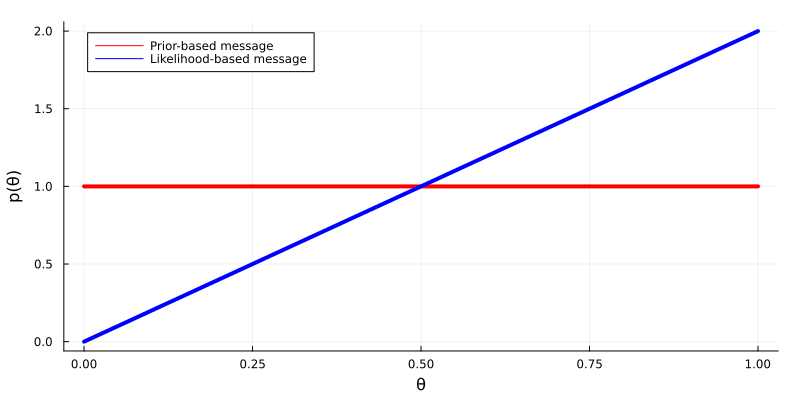

In [7]:
# Sample space of random variable
θ_range = range(0, step=0.01, stop=1.0)

# Plot messages
plot( θ_range, x -> pdf.(message1, x), color="red", label="Prior-based message", xlabel="θ", ylabel="p(θ)")
plot!(θ_range, x -> pdf.(message2, x), color="blue", label="Likelihood-based message", legend=:topleft, size=(800,400))

The marginal distribution for $\theta$, representing the posterior $p(\theta \mid X_1)$, is obtained by taking the product (followed by normalization) of the two messages: $\mu_1(\theta) \cdot \mu_2(\theta)$. Multiplying two Beta distributions produces another Beta distribution with parameter:

$$\begin{aligned} \alpha \leftarrow&\ \alpha_1 + \alpha_2 - 1 \\ \beta \leftarrow&\ \beta_1 + \beta_2 - 1 \, , \end{aligned}$$

In our case, the new parameters would be $\alpha = 1 + 2 - 1 = 2$ and $\beta = 1 + 1 - 1 = 1$. 

Let's check with RxInfer. The product of the two Beta's can be computed with:

In [8]:
prod(ProdAnalytical(), message1, message2)

Beta{Float64}(α=2.0, β=1.0)

---

Code note:
- The addition of `ProdAnalytical()` indicates to the Julia kernel that it should not use the generic `prod` function for products of `Float64`'s or `Int64`, but that it should use the product operations defined in RxInfer.jl for parametric probability distributions. The "Analytical()" hints that these operations are formula's acting on the parameters of the distributions. Approximate products based on drawing samples from the distributions are also possible.

---

That matches our manual derivations as well as the posterior reported by the `inference` procedure:

In [9]:
posterior = results.posteriors[:θ]

Beta{Float64}(α=2.0, β=1.0)

Let's visualize the messages as well as the marginal posterior.

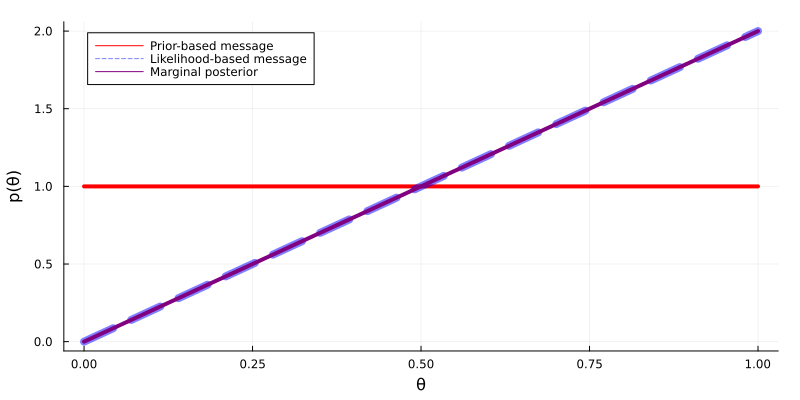

In [10]:
plot( θ_range, x -> pdf.(message1, x), color="red", label="Prior-based message", xlabel="θ", ylabel="p(θ)")
plot!(θ_range, x -> pdf.(message2, x), color="blue", linewidth=8, linestyle=:dash, alpha=0.5, label="Likelihood-based message", legend=:topleft,size=(800,400))
plot!(θ_range, x -> pdf.(posterior, x), color="purple", label="Marginal posterior")

The pdf of the marginal distribution lies on top of the pdf of Message 2. That's not always going to be the case; the Beta(1,1) distribution is special in that when you multiply Beta(1,1) with a general Beta(a,b) the result will always be Beta(a,b), kinda like multiplying by $1$. We call prior distributions that have this special effect "non-informative priors".

#### Multiple questions

Of course, in practice you would be evaluated on multiple questions, which are essentially more samples from the underlying distribution that is your skill level. We are going to add question outcomes to the model. For now, we will still work with right-or-wrong questions (i.e., binary outcomes), denoted $X = (X_1, \dots, X_N)$. The generative model becomes

$$\begin{aligned} p(X, \theta) &= p(\theta) \prod_{i=1}^{N} p(X_i \mid \theta) \\ &= \text{Beta}(\theta) \prod_{i=1}^{N} \text{Bernoulli}(X_i \mid \theta) \, , \end{aligned}$$ 

In [11]:
@model function beta_bernoulli(N)
    "Beta-Bernoulli model with multiple observations"
    
    # Allocate data variable
    X = datavar(Int64, N)
    
    # Prior distribution
    θ ~ Beta(3.0, 2.0)
        
    # Loop over data
    for i in 1:N
        
        # Likelihood of i-th data points
        X[i] ~ Bernoulli(θ)
        
    end
    return X,θ
end

You may have noticed that the prior distribution changed; the company now assumes that you must have _some_ skill if you applied for the position. This is reflected in the prior Beta distribution with $\alpha = 3.0$ and $\beta = 2.0$.

Now suppose we have two outcomes, $X_1 = 1$ and $X_2 = 0$:

In [12]:
X = [1, 0];
N = length(X);

Running the inference procedure is nearly exactly the same, except now we have to provide the sample size parameter $N$:

In [13]:
results = inference(
    model = beta_bernoulli(N),
    data  = (X = X,),
)

Inference results:
  Posteriors       | available for (θ)


We now have two likelihood-based messages:

In [14]:
message1 = @call_rule Bernoulli(:p, Marginalisation) (m_out = PointMass(X[1]),)

Beta{Float64}(α=2.0, β=1.0)

In [15]:
message2 = @call_rule Bernoulli(:p, Marginalisation) (m_out = PointMass(X[2]),)

Beta{Float64}(α=1.0, β=2.0)

Taking their product gives us a total likelihood message, i.e., 

$$\begin{aligned} \mu_3(\theta) &= \mu_1(\theta) \cdot \mu_2(\theta) \\ &= \sum_{X_1} \delta(X_1 - 1) \ \text{Bernoulli}(X_1 \mid \theta) \cdot \sum_{X_2} \delta(X_2 - 0) \ \text{Bernoulli}(X_2 \mid \theta) \\ &= \text{Beta}(\alpha = 2, \beta = 1) \cdot \text{Beta}(\alpha = 1, \beta = 2) \\ &= \text{Beta}(\alpha = 2, \beta = 2) \end{aligned}$$

Let's verify that manual calculation using RxInfer:

In [16]:
message3 = prod(ProdAnalytical(), message1, message2)

Beta{Float64}(α=2.0, β=2.0)

In essence, this message is the result of passing two likelihood-based messages through an equality node (see [Bert's lecture](https://nbviewer.org/github/bertdv/BMLIP/blob/master/lessons/notebooks/Factor-Graphs.ipynb#Equality-Nodes-for-Branching-Points)):

$$\begin{aligned} \mu_3(\theta) &= \int_{\theta'} \int_{\theta''} \overrightarrow{\mu}(\theta'')\ f_{=}(\theta, \theta', \theta'') \ \overleftarrow{\mu}(\theta') \mathrm{d}\theta' \, \mathrm{d}\theta'' \\
 &= \mu'(\theta) \cdot \mu''(\theta) \, . \end{aligned}$$

You don't have to worry about explicitly managing equality nodes when writing probabilistic programs; most packages automatically perform their operations (or functionally similar ones) under the hood.

---

#### Exercise

What would be your likelihood-based message if your data was $X = [0 \ \ 0 \ \ 0]$?

---

Now that we have a likelihood-based message, we can combine that with the message from the prior distribution, $\mu_4(\theta) = \text{Beta}(\alpha = 3, \beta = 2)$, to get the marginal posterior for $\theta$:

$$\begin{aligned} p(\theta \mid X_1, X_2) &= \mu_3(\theta) \cdot \mu_4(\theta) \\ &= \text{Beta}(\alpha = 2, \beta = 2) \cdot \text{Beta}(\alpha = 3, \beta = 2) \\ &= \text{Beta}(\alpha = 4, \beta = 3) \, . \end{aligned}$$

Let's check with RxInfer:

In [17]:
message4 = Beta(3.0, 2.0)
posterior = prod(ProdAnalytical(), message3, message4)

Beta{Float64}(α=4.0, β=3.0)

That should also be equal to the inferred posterior:

In [18]:
results.posteriors[:θ]

Beta{Float64}(α=4.0, β=3.0)

Great. That checks out.

Let's also visualize the messages and the resulting marginal:

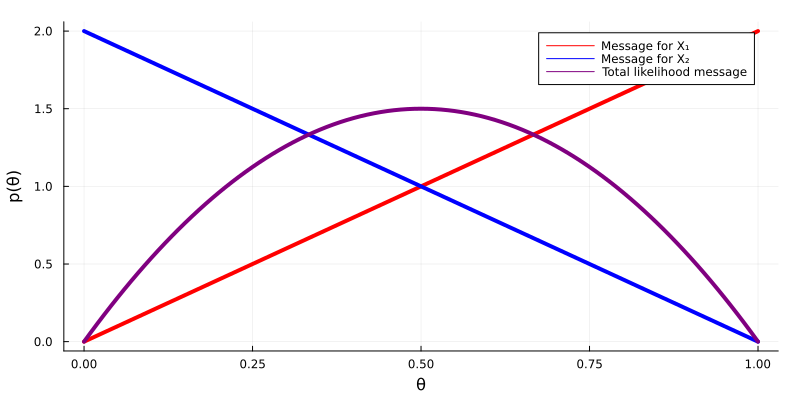

In [19]:
plot( θ_range, x -> pdf.(message1, x), color="red", label="Message for X₁", xlabel="θ", ylabel="p(θ)")
plot!(θ_range, x -> pdf.(message2, x), color="blue", label="Message for X₂", size=(800,400))
plot!(θ_range, x -> pdf.(message3, x), color="purple", label="Total likelihood message")

Message 1 and message 2 are direct opposites: the first increases the estimate and the second decreases the estimate of your skill level. The total likelihood message ends up being centered on the average, i.e., $0.5$. If we plot the prior- and likelihood-based messages as well as the marginal, we can see that Bayes' rule is really a weighted average. 

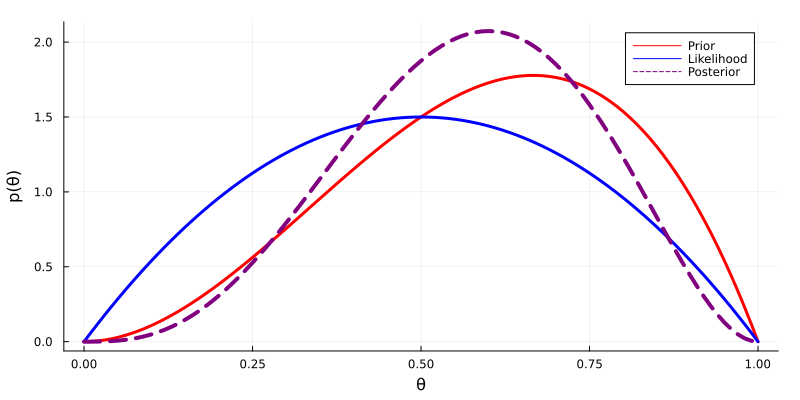

In [20]:
# Plot prior-based message
plot( θ_range, x -> pdf(message4, x), color="red", linewidth=3, label="Prior", xlabel="θ", ylabel="p(θ)")

# plot likelihood-based message
plot!(θ_range, x -> pdf(message3, x), color="blue", linewidth=3, label="Likelihood", size=(800,400))

# Plot marginal posterior
plot!(θ_range, x -> pdf(posterior, x), color="purple", linewidth=4, linestyle=:dash, label="Posterior")

### 2. Score questions

Suppose you are not tested on a right-or-wrong question, but on a score question. For instance, you have to complete a piece of code for which you get a score. If all of it was wrong you get a score of $0$, if some of it was correct you get a score of $1$ and if all of it was correct you get a score $2$. That means we have a likelihood with three outcomes: $X_1 = \{ 0,1,2\}$. Suppose we once again ask two questions, $X_1$ and $X_2$. The order in which we ask these questions does not matter, so that means we choose Categorical distributions for these likelihood functions: $X_1, X_2 \sim \text{Categorical}(\theta)$. The parameter $\theta$ is no longer a single parameter, indicating the probability of getting the question right, but a vector of three parameters: $\theta = (\theta_1, \theta_2, \theta_3)$. Each $\theta_k$ indicates the probability of getting the $k$-th outcome. In other words, $\theta_1$ indicates the probability of getting $0$ points, $\theta_2$ of getting $1$ point and $\theta_3$ of getting $2$ points. A highly-skilled applicant mights have a parameter vector of $(0.05, 0.1, 0.85)$, for example. The prior distribution conjugate to the Categorical distribution is the Dirichlet distribution. 

Let's look at the generative model:

$$p(X_1, X_2, \theta) = p(X_1 \mid \theta) p(X_2 \mid \theta) p(\theta) \, .$$ 

It's the same as before. The only difference is the parameterization of the distributions:

$$\begin{aligned} p(X_1 \mid \theta) =&\ \text{Categorical}(X_1 \mid \theta) \\ p(X_2 \mid \theta) =&\ \text{Categorical}(X_2 \mid \theta) \\ p(\theta) =&\ \text{Dirichlet}(\theta \mid \alpha) \, , \end{aligned}$$

where $\alpha$ are the concentration parameters of the Dirichlet. This model can be written directly in RxInfer:

In [21]:
@model function dirichlet_categorical(α; N=1)
    
    # Preallocate variables
    X = datavar(Vector{Int64}, N)
    
    # Prior distribution
    θ ~ Dirichlet(α)
    
    # Likelihood
    for i in 1:N
        X[i] ~ Categorical(θ)
    end
    return X,θ
end

Suppose you got a score of $1$ on the first question, a score of $2$ on the second question and a score of $2$ on the third question. In a one-hot encoding, this is represented as:

In [22]:
X = [[0, 1, 0],
     [0, 0, 1],
     [0, 0, 1]];

N = length(X);

---

#### Exercise

Compute the likelihood-based message towards $\theta$. I've given the three messages below:

In [23]:
message1 = @call_rule Categorical(:p, Marginalisation) (q_out = PointMass(X[1]),);
message2 = @call_rule Categorical(:p, Marginalisation) (q_out = PointMass(X[2]),);
message3 = @call_rule Categorical(:p, Marginalisation) (q_out = PointMass(X[3]),);

---

The company thinks that applicants are more likely to get the answer partially correct than entirely wrong or entirely right. This is reflected in their prior concentration parameters:

In [24]:
# Prior concentration parameters
α0 = [1.0, 2.0, 1.0];

The inferrred posterior is a Dirichlet distribution with higher concentrations for scores $1$ and $2$: 

In [25]:
results = inference(
    model = dirichlet_categorical(α0, N=N),
    data = (X = X,),
)

Inference results:
  Posteriors       | available for (θ)


Visualizing a Dirichlet distribution is a bit tricky. In the special case of $3$ parameters, we can plot the probabilities on a simplex. As a reminder, a [simplex](https://en.wikipedia.org/wiki/Simplex) in 3-dimensions is the triangle between the coordinates $[0,0,1]$, $[0,1,0]$ and $[1,0,0]$:

<p style="text-align:center;"><img src="https://upload.wikimedia.org/wikipedia/commons/thumb/3/38/2D-simplex.svg/150px-2D-simplex.svg.png" width="150px"></p>

Every point on that triangle is 3D vector that sums to 1. Since the triangle is a 2-dimensional subspace, we can map the 3D simplex to a 2D triangular surface and plot the Dirichlet's probability density over it.

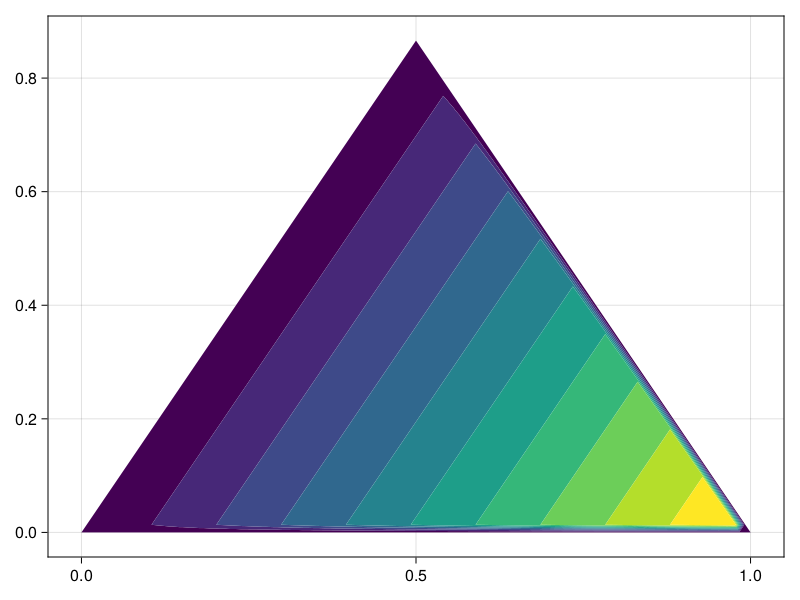

In [26]:
# Load pre-generated triangular mesh
mesh = Matrix(DataFrame(CSV.File("../datasets/trimesh.csv")))

# Compute probabilities on trimesh of simplex
pvals = [pdf(Dirichlet(α0), mesh[n,3:5]) for n in 1:size(mesh,1)]

# Generate filled contour plot
tricontourf(mesh[:,1], mesh[:,2], pvals)

The yellow spot is the area of high probability, with the contour lines indicating regions of decreasing probability. These prior concentration parameters clearly indicate a higher density in one corner of the simplex. Let's inspect the posterior concentration parameters.

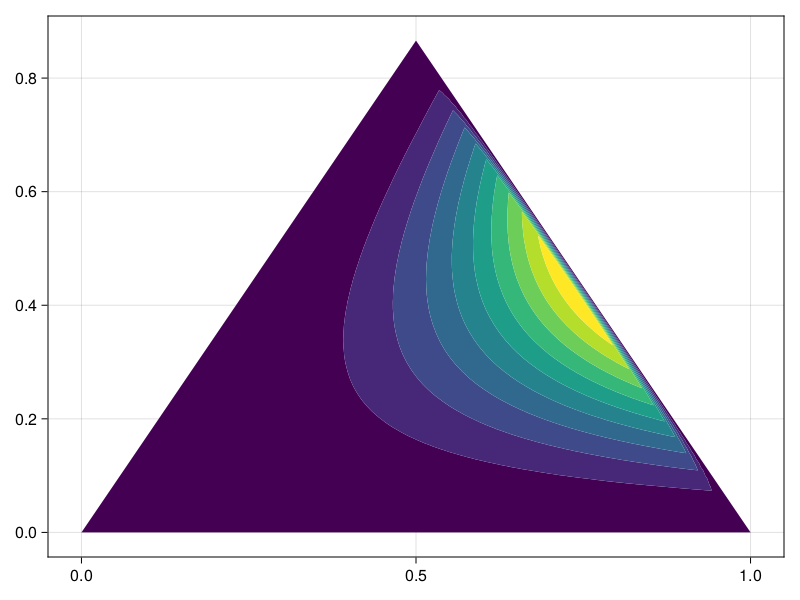

In [27]:
# Extract parameters 
αN = params(results.posteriors[:θ])[1]

# Compute probabilities on trimesh of simplex
pvals = [pdf(Dirichlet(αN), mesh[n,3:5]) for n in 1:size(mesh,1)]

# Generate filled contour plot
tricontourf(mesh[:,1], mesh[:,2], pvals)

The distribution has shifted to the upper right edge and has concentrated more (i.e., the probability contours drop off more rapidly). 

---

#### Exercise

Add some more data to the model. What scores lead to a yellow blob in the exact middle of the simplex?

---

### 3. Continuous-valued score

Suppose the company wants to know how fast applicants respond to questions. The interview conductor also has a stopwatch and measures your response time per question. Each applicant is assumed to have some underlying response speed $\theta$. Each measurement $X_i$ is a noisy observation of that response speed, where the noise is assumed to be symmetric, i.e., the applicant might a bit as faster as often as they are a bit slower than usual. The Gaussian, or Normal, distribution is a symmetric continuous-valued distribution and will characterize the assumption well. The likelihood is therefore:

$$p(X \mid \theta) = \mathcal{N}(X \mid \theta, \sigma^2) \, ,$$ 

where $\sigma$ is the standard deviation. The conjugate prior to the mean in a Gaussian likelihood is another Gaussian distribution: 

$$p(\theta) = \mathcal{N}(\theta \mid m_0, v_0)$$ 

with $m_0, v_0$ as prior mean and variance. In code, the model is:

In [28]:
@model function normal_normal(m0, v0, σ; N=1)
    
    # Allocate data variable
    X = datavar(Float64, N)
    
    # Prior distribution
    θ ~ Normal(mean = m0, variance = v0)
    
    # Likelihood
    for i = 1:N
        X[i] ~ Normal(mean = θ, variance = σ^2)
    end    
    return X,θ
end

The interview conductor cannot stop immediately after you have responded. From previous interviews, the company knows that the conductor in front of you is typically off by roughly $2$ seconds. That translates to a likelihood variance of $\sigma^2 = 4$. 

In [29]:
σ = 2.0;

Your response times on the questions are:

In [30]:
X = [ 52.390036995147426
      74.49846899398719
      50.92640384934159
      39.548361884989717]; 

N = length(X);

The company designed the questions such that they think it may take the average participant 60 seconds to respond, $\pm$ 20 seconds. That translates to the following values for the prior parameters:

In [31]:
m0 = 60;
v0 = 20;

In [32]:
results = inference(
    model = normal_normal(m0, v0, σ, N=N),
    data  = (X = X,),
)

posterior = results.posteriors[:θ]
mean_var(posterior)

(54.61030279130141, 0.9523809523809523)

Ah! It seems that you are a bit faster than the average participant.

Let's visualize the prior message, the total likelihood message and the posterior again. First, we want to get the likelihood message:

In [33]:
message = @call_rule NormalMeanVariance(:μ, Marginalisation) (m_out=PointMass(X[1]), m_v=PointMass(1.5^2))
for i in 2:N
    message_i = @call_rule NormalMeanVariance(:μ, Marginalisation) (m_out=PointMass(X[i]), m_v=PointMass(1.5^2))
    message = prod(ProdAnalytical(), message, message_i)
end
mean_var(message)

(54.34081793086648, 0.5625)

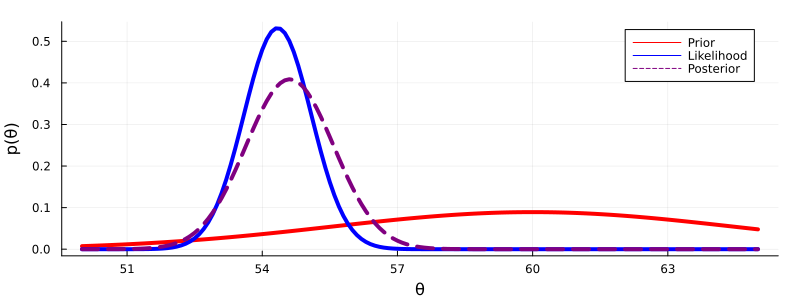

In [34]:
# Range of values to plot pdf for
θ_range = range(50.0, step=0.1, stop=65.0)

# Prior
plot( θ_range, x -> pdf(Normal(m0, sqrt(v0)), x), color="red", label="Prior", xlabel="θ", ylabel="p(θ)")

# Likelihood
plot!(θ_range, x -> pdf(message, x), color="blue", label="Likelihood")

# Posterior
plot!(θ_range, x -> pdf(posterior, x), color="purple", linestyle=:dash, label="Posterior", size=(800,300))

The prior is quite wide, indicating the company has a lot of uncertainty about participants' response speeds. The likelihood is sharply peaked, even after only 4 questions. It can clearly be seen that the posterior is a weighted average of the prior- and likelihood-based messages. In this case, it is closer to the likelihood because the likelihood variance, $4$, is much smaller than the prior variance, $20$. 

---

#### Exercise

Suppose each question was timed by a different interviewer, and that the interviewers differ vastly in how precise they record response times. How can we incorporate this knowledge into the model?

---